#### Initialization

First of all, you need to run the following cells to initialize the API and authorize your account. You must have a Google Cloud Project associated with your GEE account. Replace the `cloud_project` with your own project from [Google Cloud Console](https://console.cloud.google.com/).

We are using the [High-volume Endpoint](https://developers.google.com/earth-engine/cloud/highvolume) which supports large number of concurrent requests and is recommended when working with XEE.

In [15]:
import geemap
import ee
import pandas as pd
import geemap.foliumap as geemap
import matplotlib.pyplot as plt

#!pip install geemap
!pip install earthengine-api


# Create an interactive map.
m = geemap.Map()

In [16]:
cloud_project = 'ee-akojenuserah2ii'

try:
    ee.Initialize(
        project=cloud_project,
        opt_url='https://earthengine-highvolume.googleapis.com'
    )
except:
    ee.Authenticate()
    ee.Initialize(
        project=cloud_project,
        opt_url='https://earthengine-highvolume.googleapis.com'
    )

#### Installation

Let's install the required packages in the Colab environment.

####importing the salatelite imageries we will be working with

In [17]:
start_date = '1974-01-01'
end_date = '2024-04-01'


In [18]:
#importing the satelite imageries we need

admin2 = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level2')
terraclimate = ee.ImageCollection("IDAHO_EPSCOR/TERRACLIMATE")


"https://developers.google.com/earth-engine/datasets/catalog/IDAHO_EPSCOR_TERRACLIMATE#bands"

'https://developers.google.com/earth-engine/datasets/catalog/IDAHO_EPSCOR_TERRACLIMATE#bands'

In [19]:
#Filter for the adminitsratice boundary of interest

filteredAdmin2 = admin2.filter(ee.Filter.eq('ADM2_NAME', 'Oredo'))
geometry = filteredAdmin2.geometry()
m.centerObject(geometry, 10)
m.addLayer(filteredAdmin2, {"color": "red"}, 'Oredo')

# Display the map.
m

In [20]:
#Preprocessing

# Get the first image of the collection to find its nominal scale
first_image = terraclimate.first()
projection = first_image.projection()
nominal_scale = projection.nominalScale()

# Process the collection to scale the 'tmmx' band
scaled_tmmx = terraclimate.map(lambda image: image.select('tmmx').multiply(0.1).copyProperties(image, ['system:time_start']))

# Count the number of images in the scaled collection
num_images = scaled_tmmx.size()
print('Number of images in scaled collection:', num_images.getInfo())

# Filtering the collection based on a date range and intersecting with a geometry
# Define a date range
date_range = ee.DateRange('1974-01-01', '2024-04-01')

# Load a feature collection and filter it
features = ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level2").filter(ee.Filter.eq('ADM2_NAME', 'Oredo'))
geometry = features.geometry()

# Filter the image collection by date and location
filtered_collection = terraclimate.filterDate(date_range).filterBounds(geometry)

# Get the size of the filtered collection
filtered_collection_size = filtered_collection.size()
print('Number of images after filtering:', filtered_collection_size.getInfo())


imageVisParam = {
    "opacity": 1,
    "bands": ["tmmx"],
    "min": 19.908,
    "max": 39.492,
    "palette": [
        'blue', 'cyan', 'green', 'yellow', 'red'
    ]
}

# Create a map and add the layer
Map = geemap.Map(center=[6.5463, 5.5683], zoom=10)  # Adjust the center coordinates to your area of interest
Map.addLayer(filtered_collection.first(), imageVisParam, 'Temperature')

# Display the map
Map.addLayerControl()
Map

Number of images in scaled collection: 792
Number of images after filtering: 600


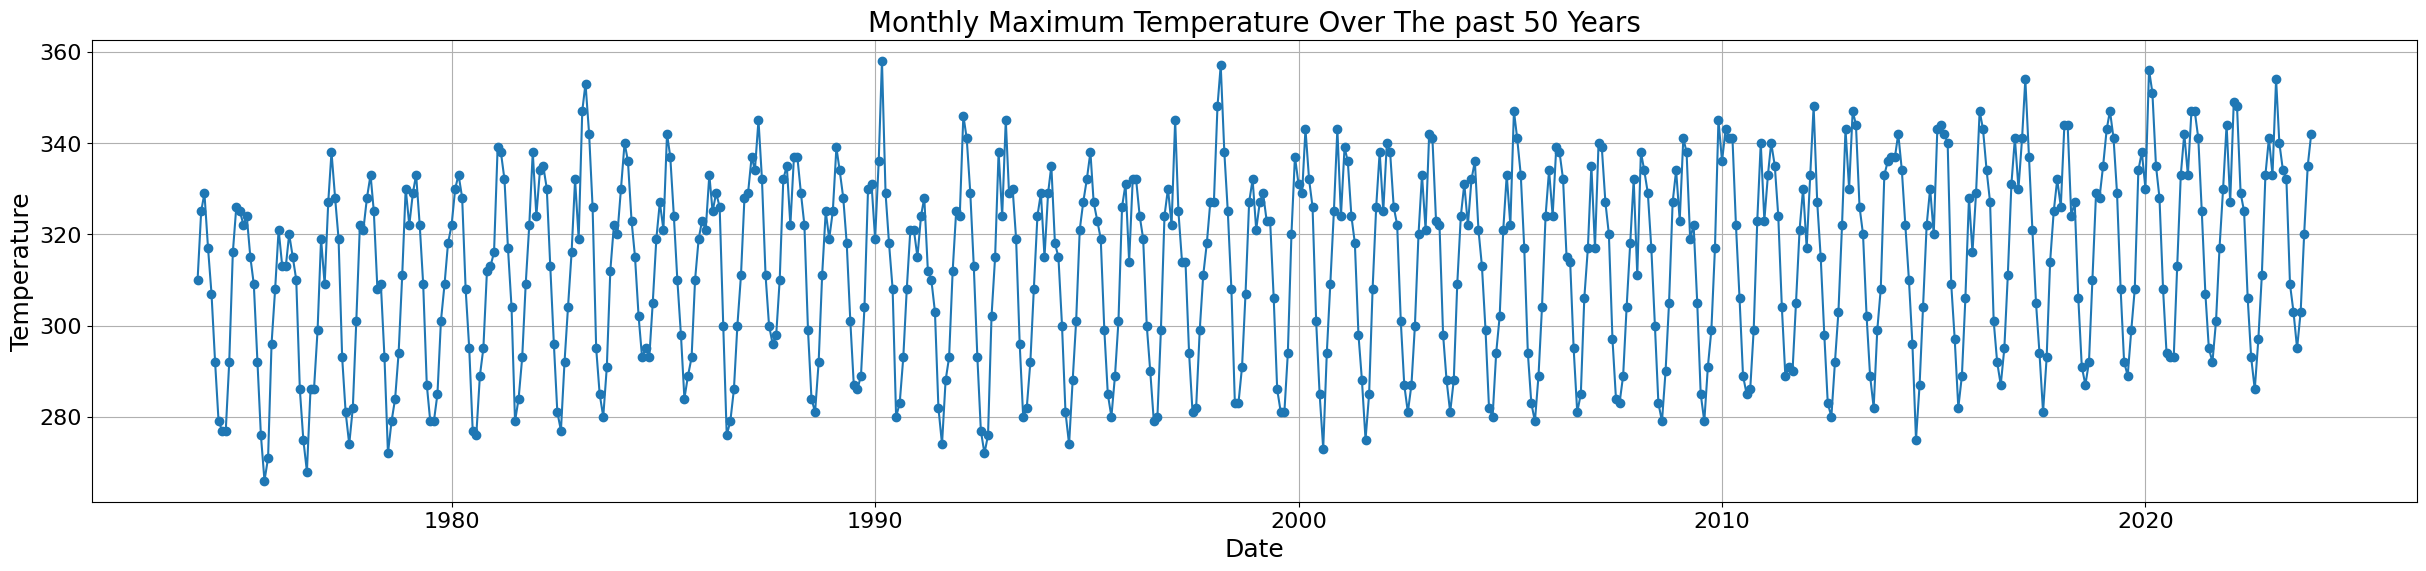

In [21]:
# Function to extract the maximum temperature for each month.
def get_monthly_max(img, geometry):

  monthly_max = img.select('tmmx').reduceRegion(
      reducer=ee.Reducer.max(),
      geometry=geometry,
      scale=1000,
      maxPixels=1e9
  )
  return ee.Feature(None, {'date': img.date().format('YYYY-MM'), 'monthly_max': monthly_max})

# Applying the function over the collection within our geometry.
monthly_max_temps = filtered_collection.map(lambda img: get_monthly_max(img, geometry))

# Extract the results. Convert getInfo() result to appropriate Python structures.
monthly_max_info = monthly_max_temps.getInfo()
features = monthly_max_info.get('features', [])

# Function to extract values from feature dictionaries
def extract_values(feature):
    date = feature['properties']['date']
    monthly_max = feature['properties']['monthly_max']['tmmx']
    return [date, monthly_max]

# Process the features list
extracted_data = [extract_values(feature) for feature in features]

# Convert to a pandas DataFrame for easy handling.
df = pd.DataFrame(extracted_data, columns=['Date', 'Max Temperature'])

# Set the date as the DataFrame index.
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

# Plot the data.
plt.figure(figsize=(30, 6))
plt.plot(df.index, df['Max Temperature'], marker='o', linestyle='-')
plt.title('Monthly Maximum Temperature Over The past 50 Years', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Temperature', fontsize=18)
plt.grid(True)
plt.show()

# Precipitation

In [22]:
#Preprocessing

# Get the first image of the collection to find its nominal scale
first_image = terraclimate.first()
projection = first_image.projection()
nominal_scale = projection.nominalScale()

# Process the collection to scale the 'tmmx' band
scaled_tmmx = terraclimate.map(lambda image: image.select('tmmx').multiply(0.1).copyProperties(image, ['system:time_start']))

# Count the number of images in the scaled collection
num_images = scaled_tmmx.size()
print('Number of images in scaled collection:', num_images.getInfo())

# Filtering the collection based on a date range and intersecting with a geometry
# Define a date range
date_range = ee.DateRange('1974-01-01', '2024-04-01')

# Load a feature collection and filter it
features = ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level2").filter(ee.Filter.eq('ADM2_NAME', 'Oredo'))
geometry = features.geometry()

# Filter the image collection by date and location
filtered_collection = terraclimate.filterDate(date_range).filterBounds(geometry)

# Get the size of the filtered collection
filtered_collection_size = filtered_collection.size()
print('Number of images after filtering:', filtered_collection_size.getInfo())


imageVisParam = {
    "opacity": 1,
    "bands": ["pr"],
    "min": 19.908,
    "max": 39.492,
    "palette": [
        'blue', 'cyan', 'green', 'yellow', 'red'
    ]
}

# Create a map and add the layer
Map = geemap.Map(center=[6.5463, 5.5683], zoom=10)  # Adjust the center coordinates to your area of interest
Map.addLayer(filtered_collection.first(), imageVisParam, 'Precipitation')

# Display the map
Map.addLayerControl()
Map

Number of images in scaled collection: 792
Number of images after filtering: 600


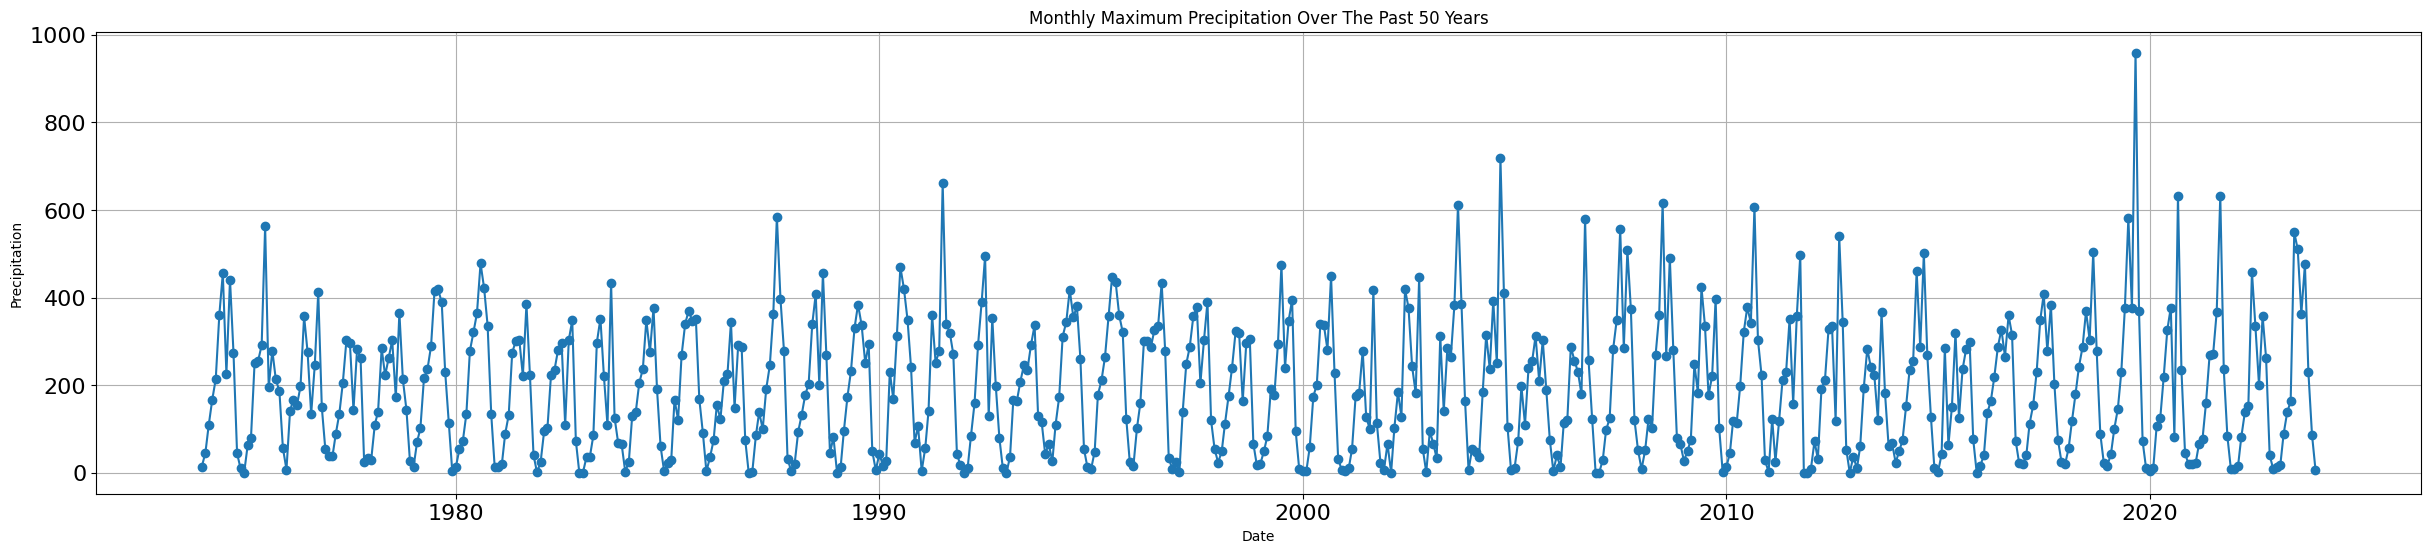

In [23]:
# Function to extract the maximum temperature for each month.
def get_monthly_max(img, geometry):

  monthly_max = img.select('pr').reduceRegion(
      reducer=ee.Reducer.max(),
      geometry=geometry,
      scale=1000,
      maxPixels=1e9
  )
  return ee.Feature(None, {'date': img.date().format('YYYY-MM'), 'monthly_max': monthly_max})

# Applying the function over the collection within our geometry.
monthly_max_temps = filtered_collection.map(lambda img: get_monthly_max(img, geometry))

# Extract the results. Convert getInfo() result to appropriate Python structures.
monthly_max_info = monthly_max_temps.getInfo()
features = monthly_max_info.get('features', [])

# Function to extract values from feature dictionaries
def extract_values(feature):
    date = feature['properties']['date']
    monthly_max = feature['properties']['monthly_max']['pr']
    return [date, monthly_max]

# Process the features list
extracted_data = [extract_values(feature) for feature in features]

# Convert to a pandas DataFrame for easy handling.
df = pd.DataFrame(extracted_data, columns=['Date', 'Max Precipitation'])

# Set the date as the DataFrame index.
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)


# Plot the data.
plt.figure(figsize=(30, 6))
plt.plot(df.index, df['Max Precipitation'], marker='o', linestyle='-')
plt.title('Monthly Maximum Precipitation Over The Past 50 Years')
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.grid(True)
plt.show()